In [1]:
import pandas as pd
import numpy as np

from ticl.evaluation.cd_plot_new.cd_plot_code import cd_evaluation
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore", FutureWarning)

# varies_over_time= ['XGBoost', 'RF', 'MLP', 'KNN', 'LogReg']

#validation_result_file = 'results/results_validation_for_paper_2024-05-16.csv'
#validation_result_file = 'results/results_validation_2024-05-20.csv'
validation_result_file = 'results/results_validation_2024-05-20.csv'
test_result_file = 'results/results_test_for_mothernet_paper_2024-05-21.csv'

#test_result_file = None

valid_results = pd.read_csv(validation_result_file, index_col=0)
rename_dict = {#'additive_Dclass_average_factorizedoutputTrue_w001_03_02_2024_02_21_10_epoch_420': 'additive class average factorized',
                                                      'additive_Dclass_average_02_29_2024_04_15_55_epoch_1050': 'additive_class_average',
                                                      'additive_1_gpu_02_14_2024_16_34_15': 'additive dense',
                                                   'mn_Dclass_average_03_25_2024_17_14_32_epoch_3970_ohe_ensemble_8': 'MotherNet',
                                                    'MotherNet': 'mothernet_old',
                                                     'additive_Dclass_average_multiclassmaxsteps3_multiclasstypesteps_03_04_2024_19_04_03_epoch_270': 'steps_prior',
                                                     #'baam_nfeatures_20_no_ensemble_e1520': 'GammaNet',
    'mothernet_ohe_ensemble_8_quantile_gpu_timing': 'MotherNet',
    'mn_categoricalfeaturep09_numfeaturessamplerdouble_sample_05_09_2024_23_39_30_epoch_1270_ohe_quantile_8': 'MotherNet',

    'batapfn_no_ensemble_e410': 'bi-attention TabPFN',
    'XGBoost': 'XGBoost$^\dag$',
    'KNN': 'KNN$^\dag$',
    'mlp_gpu2': 'MLP$^\ddag$',
    'resnet_gpu': 'ResNet$^\ddag$',
    'mn_categoricalfeaturep09_numfeaturessamplerdouble_sample_05_09_2024_23_39_30_epoch_1270_ohe_quantile_8_cpu_timing3': 'MotherNet (CPU)',
    #'ebm_default': 'EBM (interactions)',
    #'ebm_bins_main_effects': 'EBM (main effects)',
    'hyperfast_no_optimize_gpu': 'HyperFast no FT',
    'hyperfast_defaults_gpu' : 'HyperFast default',
    'hyperfast_tuning_gpu': 'HyperFast$^\ddag$',
    'LogReg': 'Logistic Regression$^\dag$',
     'RF': 'RandomForest$^\dag$',
    'mothernet_init_gd_no_learning_preprocess2': 'MotherNet NE',
    'mothernet_gd_gpu4': 'MotherNet FT$^\ddag$',
    'TabPFN (Hollmann)': 'TabPFN',
    "MotherNet": "MotherNet_old",
    
   # 'MLP-Distill': 'mlp_distill',
    #'MLP': 'MLP (60 min HPO)',
    'MLP': 'MLP_drop',
    'TabPFN (ours)': 'tabpfn_ours_hide'}
#valid_results.model.unique()
#valid_results['model'] = valid_results.model.replace({'hyperfast_defaults_cpu': 'hyperfast_defaults_gpu'}) ## HACCCKKK
valid_results['model'] = valid_results.model.replace(rename_dict)

valid_results = valid_results[valid_results.model != "hyperfast_no_optimize_cpu"]
valid_results = valid_results[~valid_results.model.str.contains('_')]
all_models = valid_results.model.unique()



In [2]:
all_models

array(['KNN$^\\dag$', 'RandomForest$^\\dag$', 'XGBoost$^\\dag$',
       'Logistic Regression$^\\dag$', 'MLP-Distill', 'TabPFN',
       'HyperFast no FT', 'HyperFast default', 'MotherNet'], dtype=object)

In [3]:
if test_result_file:
    test_results = pd.read_csv(test_result_file, index_col=0)
    test_results['model'] = test_results.model.replace(rename_dict)
    test_results = test_results[~test_results.model.str.contains('_')]
    all_models = set(valid_results.model.unique()).union(set(test_results.model.unique()))

    print(test_results.model.unique())
    print(valid_results.model.unique())
    assert set(test_results.model.unique()) == set(valid_results.model.unique())

['KNN$^\\dag$' 'RandomForest$^\\dag$' 'XGBoost$^\\dag$'
 'Logistic Regression$^\\dag$' 'MLP-Distill' 'TabPFN' 'MotherNet NE'
 'HyperFast no FT' 'HyperFast default' 'MotherNet' 'MotherNet (CPU)'
 'HyperFast$^\\ddag$' 'MLP$^\\ddag$' 'ResNet$^\\ddag$'
 'MotherNet FT$^\\ddag$']
['KNN$^\\dag$' 'RandomForest$^\\dag$' 'XGBoost$^\\dag$'
 'Logistic Regression$^\\dag$' 'MLP-Distill' 'TabPFN' 'HyperFast no FT'
 'HyperFast default' 'MotherNet']


AssertionError: 

In [4]:
color_palette = sns.color_palette(n_colors=len(all_models))
color_mapping = dict(zip(all_models, color_palette))

In [5]:
def get_best_over_time(results):
    max_time_per_dataset_model = results.groupby(["dataset", "model"])["max_time"].max().rename('max_time_overall')
    average_over_splits = results.groupby(["dataset", "model", "max_time"])[["mean_metric", "fit_time", "inference_time"]].mean()
    joined_with_max_time = average_over_splits.join(max_time_per_dataset_model).reset_index()
    return joined_with_max_time[joined_with_max_time.max_time == joined_with_max_time.max_time_overall]

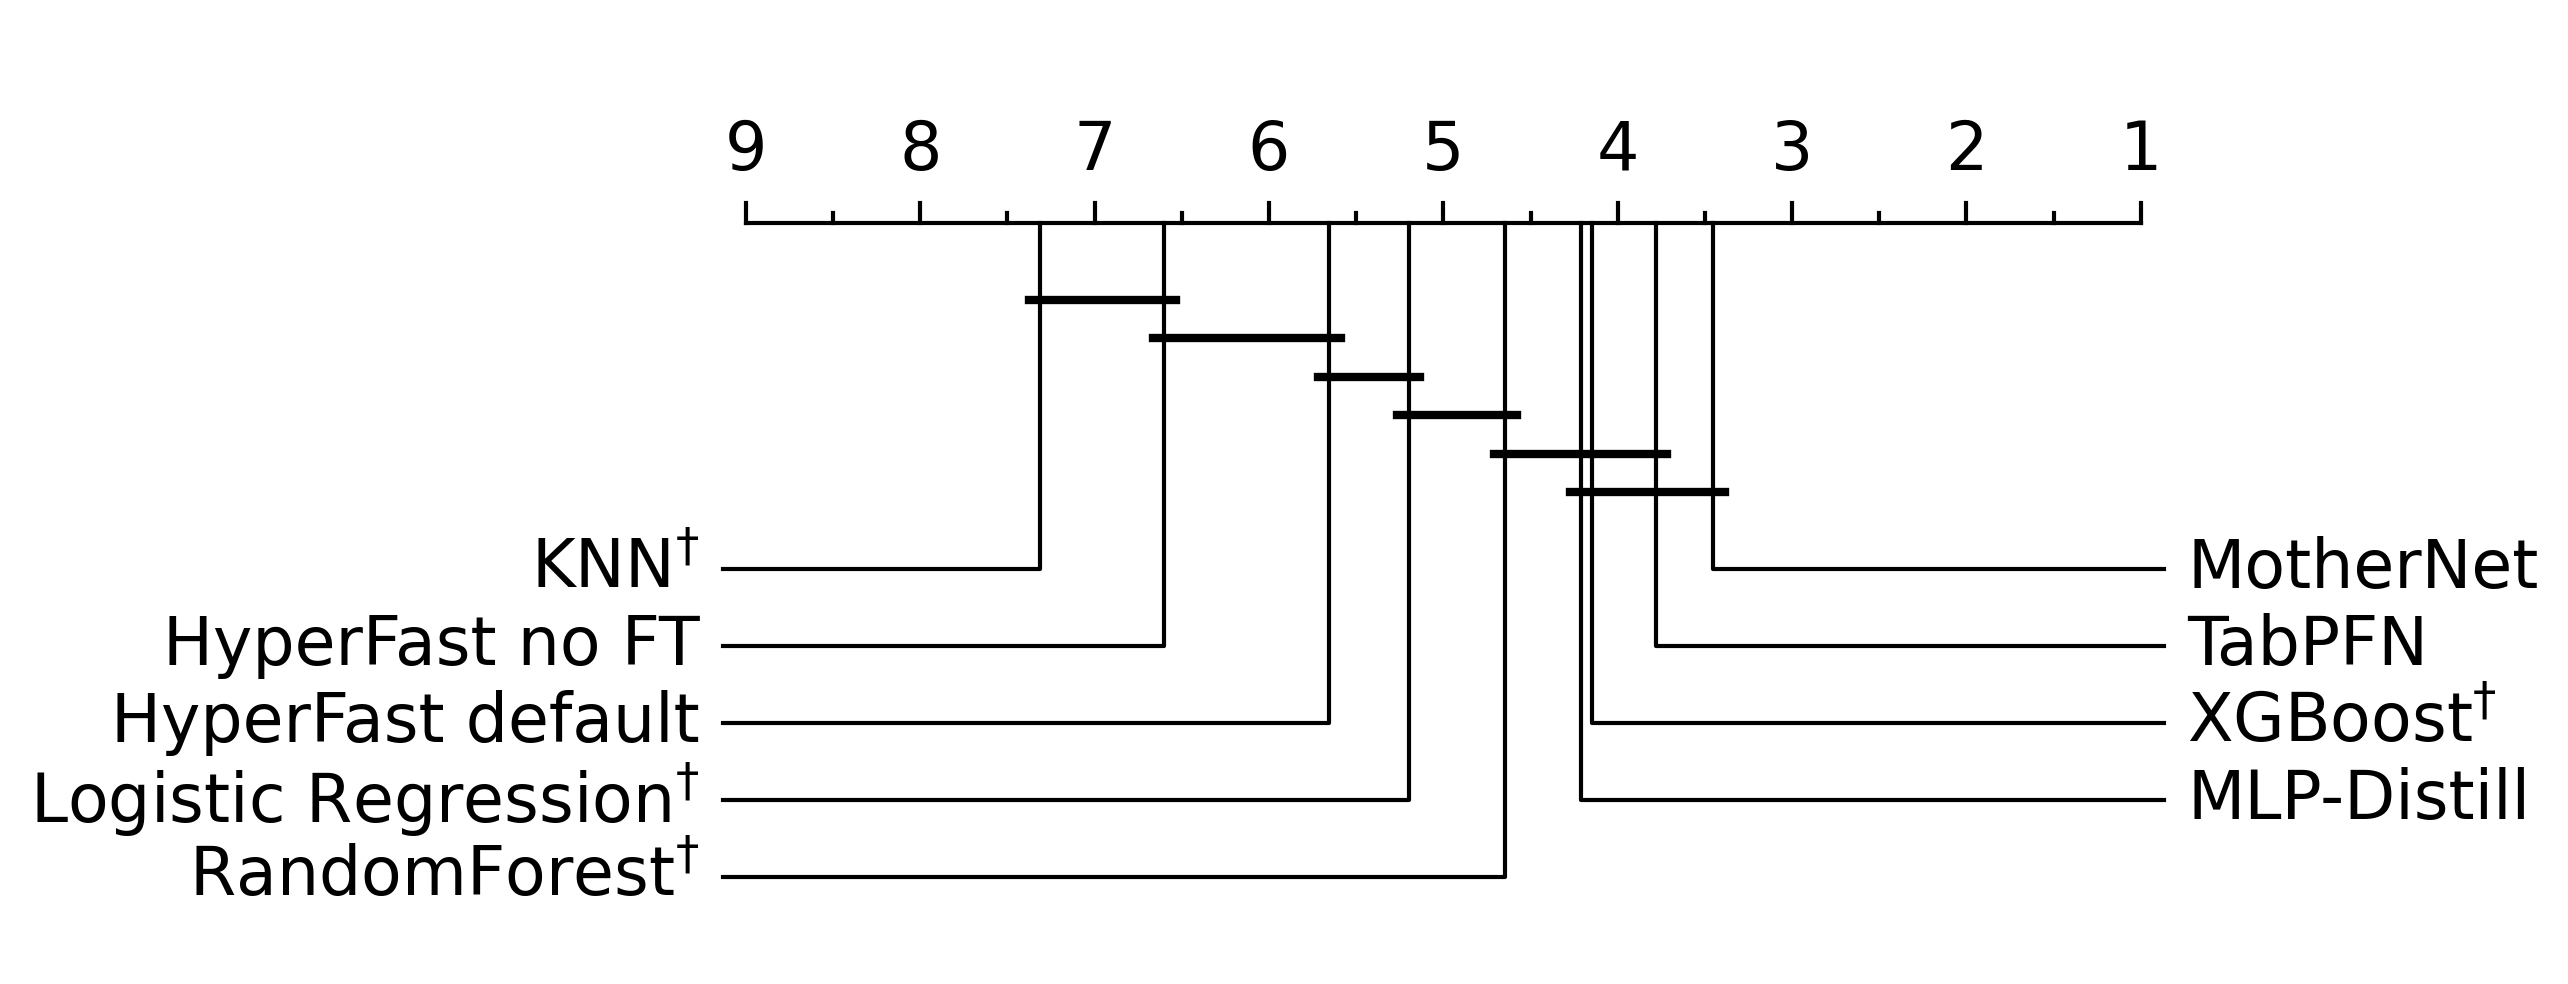

In [6]:
plt.figure(figsize=(8, 4), dpi=300)
combined_best_valid = get_best_over_time(valid_results)
pivoted_for_cd = combined_best_valid.pivot(index="dataset", columns="model", values="mean_metric")
_ = cd_evaluation(pivoted_for_cd, maximize_metric=True, ax=plt.gca())
plt.savefig("../figures/cd_diagram_validation.pdf", bbox_inches="tight")

In [7]:
def hide_for_plots(df):
    #hidden_models = ["MotherNet (CPU)", 'MotherNet (no baggging)','MotherNet plus Gradient Descent$^\\ddag$']
    hidden_models = ["MotherNet (CPU)"]
    return df[~df.model.isin(hidden_models)]

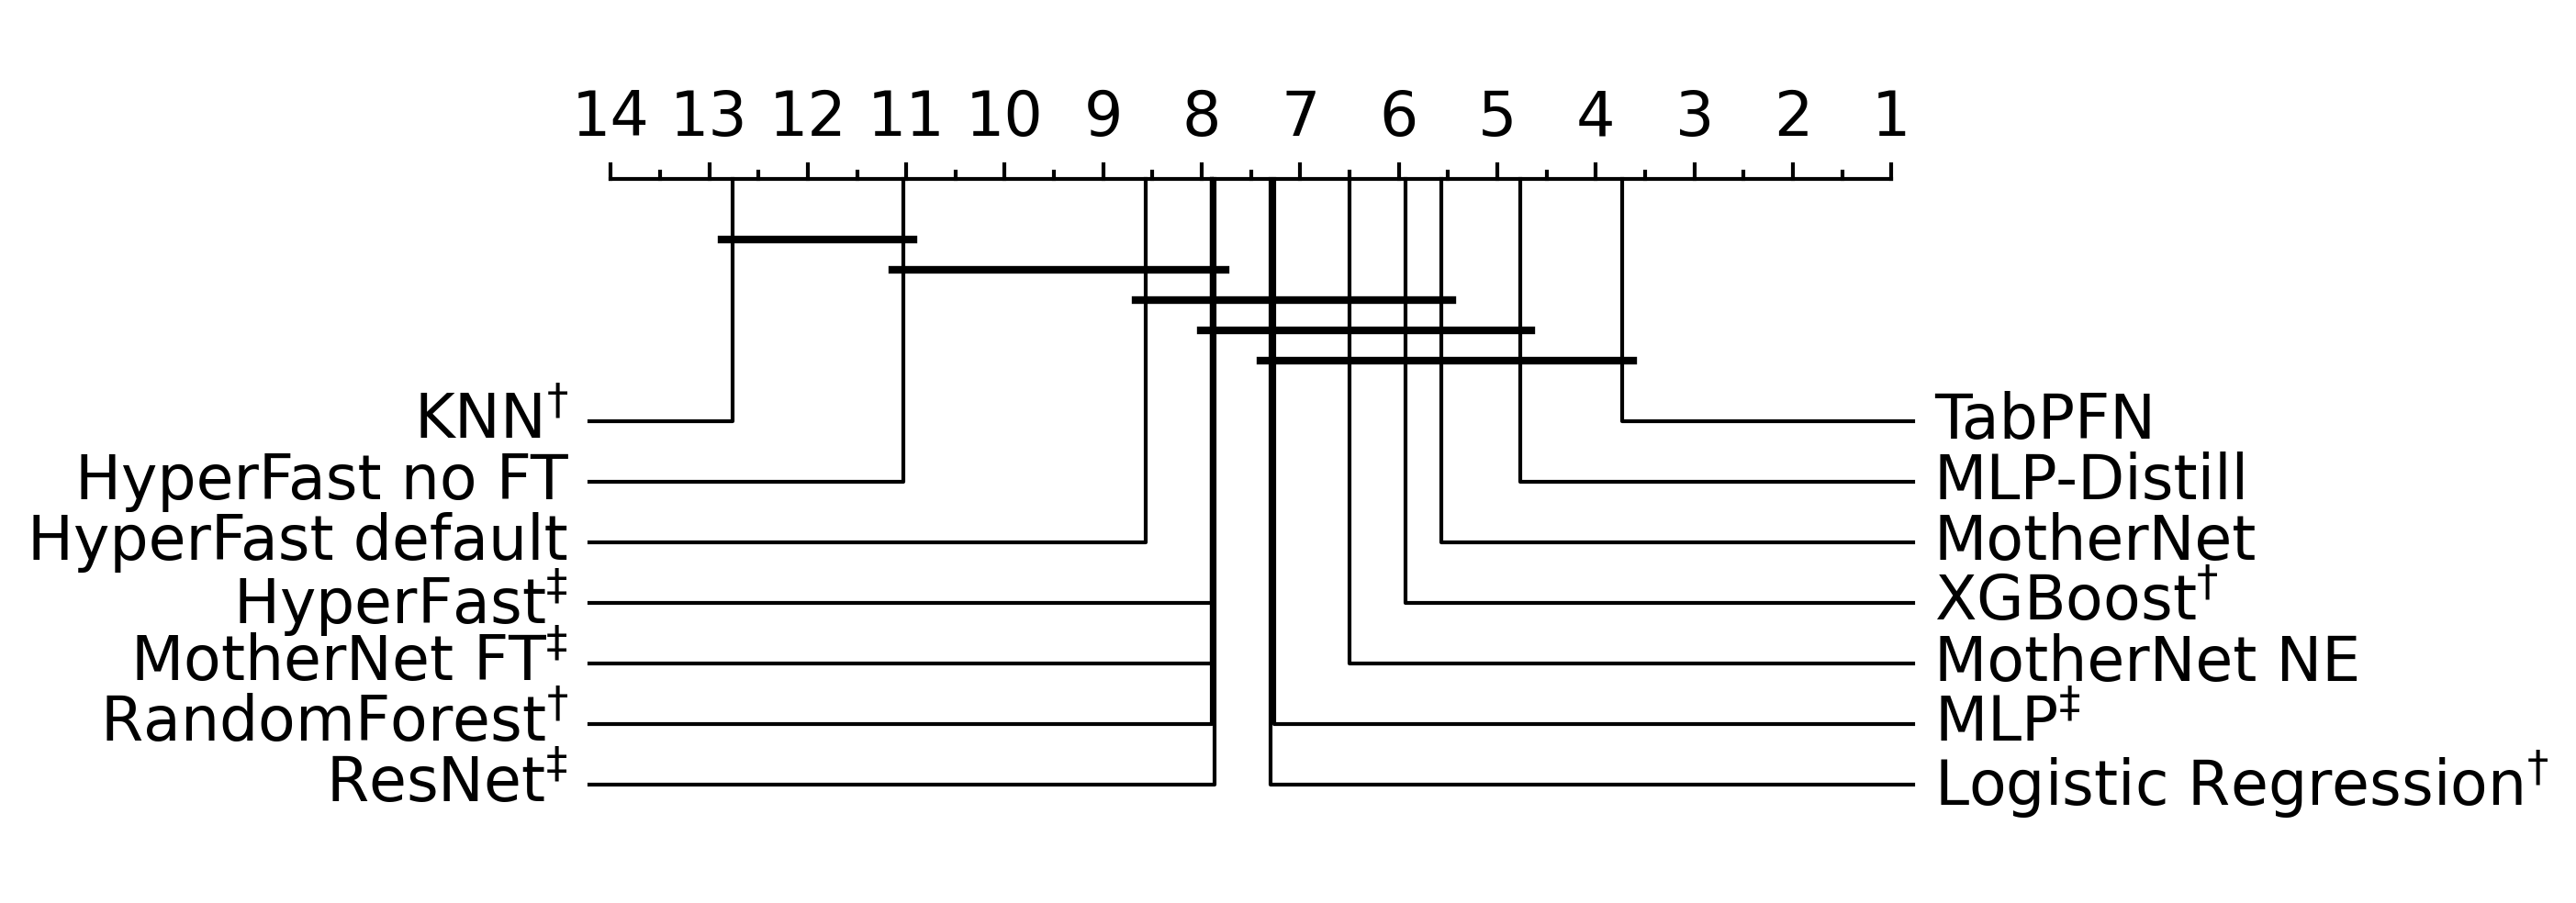

In [8]:
if test_result_file:
    plt.figure(figsize=(8, 4), dpi=300)
    combined_best_test = get_best_over_time(hide_for_plots(test_results))
    #combined_best_test = get_best_over_time(test_results)

    
    pivoted_for_cd_test = combined_best_test.pivot(index="dataset", columns="model", values="mean_metric")
    _ = cd_evaluation(pivoted_for_cd_test, maximize_metric=True, ax=plt.gca())
    plt.savefig("../figures/cd_diagram_test.pdf", bbox_inches="tight")

In [11]:
# combined_best_test_norms = combined_best_test.merge(combined_best_test.groupby("dataset").mean_metric.max().rename("max_auc"), left_on="dataset", right_index=True)
# combined_best_test_norms = combined_best_test_norms.merge(combined_best_test.groupby("dataset").mean_metric.min().rename("min_auc"), left_on="dataset", right_index=True)
# combined_best_test_norms['Normalized ROC AUC'] = (combined_best_test_norms.mean_metric - combined_best_test_norms.min_auc) / (combined_best_test_norms.max_auc - combined_best_test_norms.min_auc)


In [9]:
def get_varies_over_time(results):
    times = results.groupby(["dataset", "model", "split"]).size().unstack("model").reset_index(drop=True).apply(pd.unique)
    assert len(times) == 1
    times = times.T
    return times.index[times[0] > 1]

def compare_splits(results):
    varies_over_time = get_varies_over_time(results)
    compare_splits_over_time = results.groupby(["model", "split", "max_time"])[['mean_metric', 'fit_time', 'inference_time']].mean().reset_index()
    compare_splits_varies = compare_splits_over_time[compare_splits_over_time.model.isin(varies_over_time)]
    compare_splits_fixed = compare_splits_over_time[~compare_splits_over_time.model.isin(varies_over_time)]
    compare_splits_varies_last = compare_splits_varies[compare_splits_varies.max_time == compare_splits_varies.max_time.max()]
    return compare_splits_over_time, pd.concat([compare_splits_fixed, compare_splits_varies_last])

In [10]:
compare_splits_over_time_valid, compare_splits_valid = compare_splits(valid_results)
if test_result_file:
    compare_splits_over_time_test, compare_splits_test = compare_splits(test_results)

In [11]:
compare_splits_test.model.unique()

array(['HyperFast default', 'HyperFast no FT', 'HyperFast$^\\ddag$',
       'MLP$^\\ddag$', 'MLP-Distill', 'MotherNet', 'MotherNet (CPU)',
       'MotherNet FT$^\\ddag$', 'MotherNet NE', 'ResNet$^\\ddag$',
       'TabPFN', 'KNN$^\\dag$', 'Logistic Regression$^\\dag$',
       'RandomForest$^\\dag$', 'XGBoost$^\\dag$'], dtype=object)

In [12]:
compare_splits_test

,model,split,max_time,mean_metric,fit_time,inference_time
0,HyperFast default,1,1,0.871031,25.921448,0.045736
1,HyperFast default,2,1,0.874253,25.936376,0.045678
2,HyperFast default,3,1,0.872247,25.944714,0.045705
3,HyperFast default,4,1,0.871181,26.003774,0.045747
4,HyperFast default,5,1,0.876239,25.994218,0.045641
...,...,...,...,...,...,...
166,XGBoost$^\dag$,1,3600,0.892359,6.723667,0.033228
173,XGBoost$^\dag$,2,3600,0.894503,4.535582,0.023492
180,XGBoost$^\dag$,3,3600,0.886975,5.508178,0.026886
187,XGBoost$^\dag$,4,3600,0.891691,4.674549,0.016897


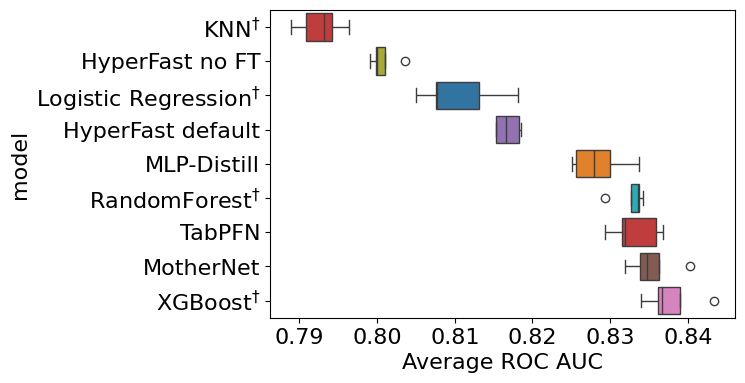

In [13]:
plt.figure(figsize=(6, 4))
compare_splits_valid = compare_splits_valid[~compare_splits_valid.model.isin(["KNN", "Neural Network"])]
order = compare_splits_valid.groupby("model").mean("mean_metric").sort_values("mean_metric").index
sns.boxplot(data=compare_splits_valid, y="model", x="mean_metric", order=order, ax=plt.gca(), palette=color_mapping)
#sns.boxplot(data=compare_splits_valid, y="model", x="mean_metric",order=order, ax=plt.gca(), hue="model")

plt.xlabel("Average ROC AUC")
plt.savefig("../figures/mean_roc_auc_validation.pdf", dpi=300, bbox_inches="tight")

In [14]:
compare_splits_test.model.unique()

array(['HyperFast default', 'HyperFast no FT', 'HyperFast$^\\ddag$',
       'MLP$^\\ddag$', 'MLP-Distill', 'MotherNet', 'MotherNet (CPU)',
       'MotherNet FT$^\\ddag$', 'MotherNet NE', 'ResNet$^\\ddag$',
       'TabPFN', 'KNN$^\\dag$', 'Logistic Regression$^\\dag$',
       'RandomForest$^\\dag$', 'XGBoost$^\\dag$'], dtype=object)

In [15]:
hide_for_plots(compare_splits_test_no_cpu).model.unique()

NameError: name 'compare_splits_test_no_cpu' is not defined

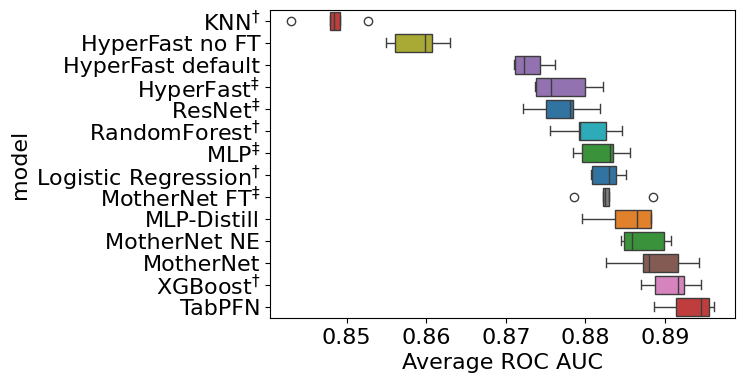

In [16]:
if test_result_file:
    plt.figure(figsize=(6, 4))
    compare_splits_test_no_cpu = hide_for_plots(compare_splits_test)
    order = compare_splits_test_no_cpu.groupby("model").mean("mean_metric").sort_values("mean_metric").index
    sns.boxplot(data=compare_splits_test_no_cpu, y="model", x="mean_metric", order=order, ax=plt.gca(), palette=color_mapping)
    plt.xlabel("Average ROC AUC")
    plt.savefig("../figures/mean_roc_auc_test.pdf", dpi=300, bbox_inches="tight")

In [17]:
def normalize_metric(results):
    dataset_min_max = results.groupby("dataset").mean_metric.agg(["min", "max"])
    results_normalized = results.merge(dataset_min_max, on="dataset")
    results_normalized['mean_metric'] = (results_normalized['mean_metric'] - results_normalized['min']) / (results_normalized['max'] - results_normalized['min'])
    return results_normalized

In [18]:
compare_splits_over_time_valid_normalized, compare_splits_valid_normalized = compare_splits(normalize_metric(valid_results))
if test_result_file:
    compare_splits_over_time_test_normalized, compare_splits_test_normalized = compare_splits(normalize_metric(test_results))

In [19]:
compare_splits_test_normalized

,model,split,max_time,mean_metric,fit_time,inference_time
0,HyperFast default,1,1,0.665739,25.921448,0.045736
1,HyperFast default,2,1,0.701237,25.936376,0.045678
2,HyperFast default,3,1,0.658257,25.944714,0.045705
3,HyperFast default,4,1,0.678194,26.003774,0.045747
4,HyperFast default,5,1,0.702729,25.994218,0.045641
...,...,...,...,...,...,...
166,XGBoost$^\dag$,1,3600,0.817559,6.723667,0.033228
173,XGBoost$^\dag$,2,3600,0.835423,4.535582,0.023492
180,XGBoost$^\dag$,3,3600,0.762554,5.508178,0.026886
187,XGBoost$^\dag$,4,3600,0.807341,4.674549,0.016897


In [20]:
compare_splits_test_normalized.to_csv("test_auc_normalized_per_split_gams.csv")

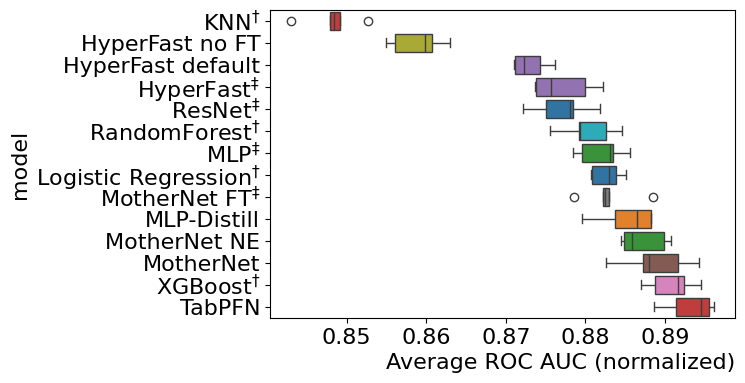

In [21]:
if test_result_file:
    plt.figure(figsize=(6, 4))
    compare_splits_test_normalized_no_cpu = hide_for_plots(compare_splits_test)
    order = compare_splits_test_normalized_no_cpu.groupby("model").mean("mean_metric").sort_values("mean_metric").index
    sns.boxplot(data=compare_splits_test_normalized_no_cpu, y="model", x="mean_metric", order=order, ax=plt.gca(), palette=color_mapping)
    plt.xlabel("Average ROC AUC (normalized)", loc="right")
    plt.savefig("../figures/mean_roc_auc_test_normalized.pdf", dpi=300, bbox_inches="tight")

In [22]:
# table.drop(index=["mothernet_old", "mlp_distill", 'KNN']).rename({'mn_Dclass_average_03_25_2024_17_14_32_epoch_2910_ohe_ensemble_8': 'MotherNet'})

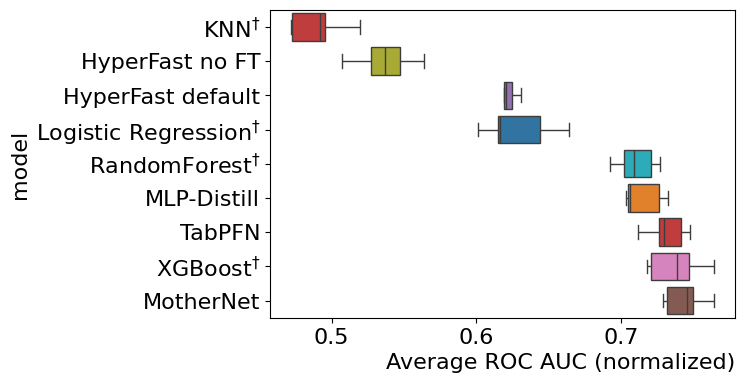

In [24]:
plt.figure(figsize=(6, 4))
compare_splits_valid_normalized = compare_splits_valid_normalized[~compare_splits_valid_normalized.model.isin(["KNN", "Neural Network"])]
order = compare_splits_valid_normalized.groupby("model").mean("mean_metric").sort_values("mean_metric").index
sns.boxplot(data=compare_splits_valid_normalized, y="model", x="mean_metric", order=order, ax=plt.gca(), palette=color_mapping)
#sns.boxplot(data=compare_splits_valid_normalized, y="model", x="mean_metric", order=order, ax=plt.gca(), hue='model')

plt.xlabel("Average ROC AUC (normalized)", loc="right")
plt.savefig("../figures/mean_roc_auc_valid_normalized.pdf", dpi=300, bbox_inches="tight")

In [25]:
compare_splits_test_normalized.model.unique()

array(['HyperFast default', 'HyperFast no FT', 'HyperFast$^\\ddag$',
       'MLP$^\\ddag$', 'MLP-Distill', 'MotherNet', 'MotherNet (CPU)',
       'MotherNet FT$^\\ddag$', 'MotherNet NE', 'ResNet$^\\ddag$',
       'TabPFN', 'KNN$^\\dag$', 'Logistic Regression$^\\dag$',
       'RandomForest$^\\dag$', 'XGBoost$^\\dag$'], dtype=object)

In [26]:
def make_score_table(split_df, metric_name):
    split_df_groupby = split_df.rename(columns={'mean_metric': metric_name}).groupby("model")[['fit_time', 'inference_time', metric_name]]
    split_df_mean = split_df_groupby.mean()
    split_df_std = split_df_groupby.std()
    return split_df_mean.merge(split_df_std, on="model", suffixes=("", " std"))

In [27]:
compare_splits_test

,model,split,max_time,mean_metric,fit_time,inference_time
0,HyperFast default,1,1,0.871031,25.921448,0.045736
1,HyperFast default,2,1,0.874253,25.936376,0.045678
2,HyperFast default,3,1,0.872247,25.944714,0.045705
3,HyperFast default,4,1,0.871181,26.003774,0.045747
4,HyperFast default,5,1,0.876239,25.994218,0.045641
...,...,...,...,...,...,...
166,XGBoost$^\dag$,1,3600,0.892359,6.723667,0.033228
173,XGBoost$^\dag$,2,3600,0.894503,4.535582,0.023492
180,XGBoost$^\dag$,3,3600,0.886975,5.508178,0.026886
187,XGBoost$^\dag$,4,3600,0.891691,4.674549,0.016897


In [28]:
compare_splits_test_normalized

,model,split,max_time,mean_metric,fit_time,inference_time
0,HyperFast default,1,1,0.665739,25.921448,0.045736
1,HyperFast default,2,1,0.701237,25.936376,0.045678
2,HyperFast default,3,1,0.658257,25.944714,0.045705
3,HyperFast default,4,1,0.678194,26.003774,0.045747
4,HyperFast default,5,1,0.702729,25.994218,0.045641
...,...,...,...,...,...,...
166,XGBoost$^\dag$,1,3600,0.817559,6.723667,0.033228
173,XGBoost$^\dag$,2,3600,0.835423,4.535582,0.023492
180,XGBoost$^\dag$,3,3600,0.762554,5.508178,0.026886
187,XGBoost$^\dag$,4,3600,0.807341,4.674549,0.016897


In [29]:
normed_table = make_score_table(compare_splits_test_normalized, "Normalized ROC AUC")
unnormed_table = make_score_table(compare_splits_test, "ROC AUC")

In [30]:
pivoted_for_cd_test

model,HyperFast default,HyperFast no FT,HyperFast$^\ddag$,KNN$^\dag$,Logistic Regression$^\dag$,MLP$^\ddag$,MLP-Distill,MotherNet,MotherNet FT$^\ddag$,MotherNet NE,RandomForest$^\dag$,ResNet$^\ddag$,TabPFN,XGBoost$^\dag$
dataset,,,,,,,,,,,,,,
MiceProtein,0.999975,0.988606,0.999979,0.997160,0.999254,0.999704,0.999800,0.998348,0.995143,0.996382,0.999188,0.999957,0.999578,0.999776
analcatdata_authorship,0.999931,0.999933,0.999930,0.999763,0.999965,0.999945,0.999977,0.999990,0.999943,0.999949,0.999687,0.999948,0.999988,0.999920
analcatdata_dmft,0.526849,0.554439,0.560911,0.546662,0.569513,0.566935,0.576845,0.570724,0.547026,0.559468,0.585847,0.538061,0.576601,0.570857
balance-scale,0.992595,0.885619,0.992852,0.885090,0.961861,0.994421,0.992246,0.996780,0.993361,0.993849,0.840023,0.968915,0.996911,0.990811
banknote-authentication,1.000000,0.984273,1.000000,0.999211,0.999728,1.000000,1.000000,1.000000,1.000000,1.000000,0.999684,1.000000,1.000000,0.999995
blood-transfusion-service-center,0.714981,0.739178,0.732298,0.708473,0.749845,0.733690,0.757076,0.758114,0.757978,0.759891,0.721215,0.740112,0.756096,0.736017
breast-w,0.992054,0.992034,0.990352,0.984045,0.993937,0.991927,0.994349,0.993400,0.993755,0.993516,0.990647,0.991983,0.993417,0.991548
car,0.994874,0.921184,0.990115,0.915854,0.982618,0.995749,0.985040,0.965375,0.976905,0.969303,0.994567,0.996065,0.995364,0.995442
climate-model-simulation-crashes,0.908414,0.914109,0.903066,0.848553,0.932231,0.913469,0.911046,0.946996,0.934504,0.943353,0.871042,0.916895,0.942607,0.928573


In [31]:
ranks_test = pivoted_for_cd_test.T.rank(ascending=False).mean(axis=1).rename("rank")
result_table = unnormed_table.merge(normed_table.drop(columns=["inference_time", "fit_time", "inference_time std", "fit_time std"]), left_index=True, right_index=True).merge(ranks_test, left_on="model", right_index=True, how="left").sort_values("rank")


In [32]:
result_table['fit+predict'] = result_table['fit_time'] + result_table['inference_time']

In [33]:
pd.set_option("display.float_format", lambda x: f"{x:.3f}")

result_table[['rank', 'Normalized ROC AUC', 'Normalized ROC AUC std', 'ROC AUC', 'ROC AUC std', 'fit_time', 'inference_time', 'fit+predict']]

,rank,Normalized ROC AUC,Normalized ROC AUC std,ROC AUC,ROC AUC std,fit_time,inference_time,fit+predict
model,,,,,,,,
TabPFN,3.733,0.850,0.026,0.893,0.003,0.008,0.337,0.344
MLP-Distill,4.767,0.802,0.027,0.885,0.004,4.382,0.002,4.384
MotherNet,5.567,0.780,0.037,0.889,0.004,0.136,0.006,0.143
XGBoost$^\dag$,5.933,0.804,0.027,0.891,0.003,4.912,0.024,4.936
MotherNet NE,6.500,0.716,0.026,0.887,0.003,0.040,0.001,0.040
MLP$^\ddag$,7.267,0.744,0.025,0.882,0.003,2.257,0.001,2.258
Logistic Regression$^\dag$,7.300,0.749,0.024,0.883,0.002,0.209,0.000,0.209
ResNet$^\ddag$,7.867,0.710,0.025,0.877,0.004,1.668,0.001,1.669
RandomForest$^\dag$,7.900,0.732,0.020,0.880,0.003,0.200,0.032,0.232


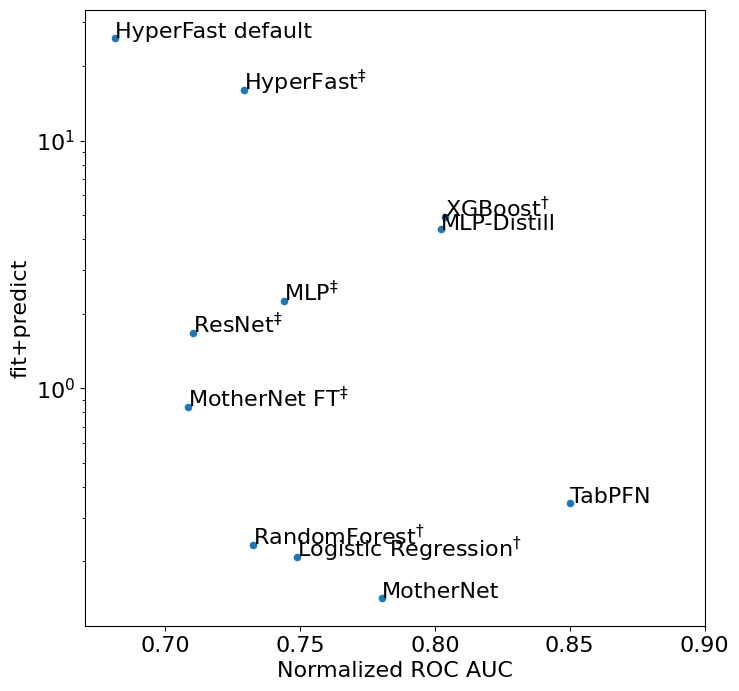

In [34]:
plt.figure(figsize=(8, 8))
for_scatter_plot = result_table.dropna(subset="rank").drop(index=["KNN$^\dag$", "HyperFast no FT", "MotherNet NE"])
#for_scatter_plot = result_table.dropna(subset="rank").drop(index=["KNN$^\dag$"])
for_scatter_plot.plot(x="Normalized ROC AUC", y="fit+predict", kind="scatter", ax=plt.gca())
for  name, row in for_scatter_plot.iterrows():
    plt.text(row["Normalized ROC AUC"], row["fit+predict"], name)
plt.yscale("log")
plt.xlim(0.67, 0.9)
plt.savefig("../figures/time_roc_scatter.pdf", dpi=300, bbox_inches="tight")

In [35]:
all_times = compare_splits_over_time_test_normalized.groupby(["model", "max_time"]).mean().drop(columns="split").reset_index()
all_times.loc[all_times.max_time == 1, "max_time"] = 0

In [36]:
all_times.model.unique()

array(['HyperFast default', 'HyperFast no FT', 'HyperFast$^\\ddag$',
       'KNN$^\\dag$', 'Logistic Regression$^\\dag$', 'MLP$^\\ddag$',
       'MLP-Distill', 'MotherNet', 'MotherNet (CPU)',
       'MotherNet FT$^\\ddag$', 'MotherNet NE', 'RandomForest$^\\dag$',
       'ResNet$^\\ddag$', 'TabPFN', 'XGBoost$^\\dag$'], dtype=object)

In [37]:
all_times.model = all_times.model.str.replace('HyperFast default', 'HyperFast').replace('HyperFast no FT', 'HyperFast').replace('HyperFast$^\ddag$', 'HyperFast')
all_times = all_times[all_times.model != 'MotherNet (CPU)']

HyperFast
KNN$^\dag$
Logistic Regression$^\dag$
MLP$^\ddag$
MLP-Distill
MotherNet
MotherNet NE
RandomForest$^\dag$
ResNet$^\ddag$
TabPFN
XGBoost$^\dag$


Text(0.5, 0, 'Mean normalized ROC AUC')

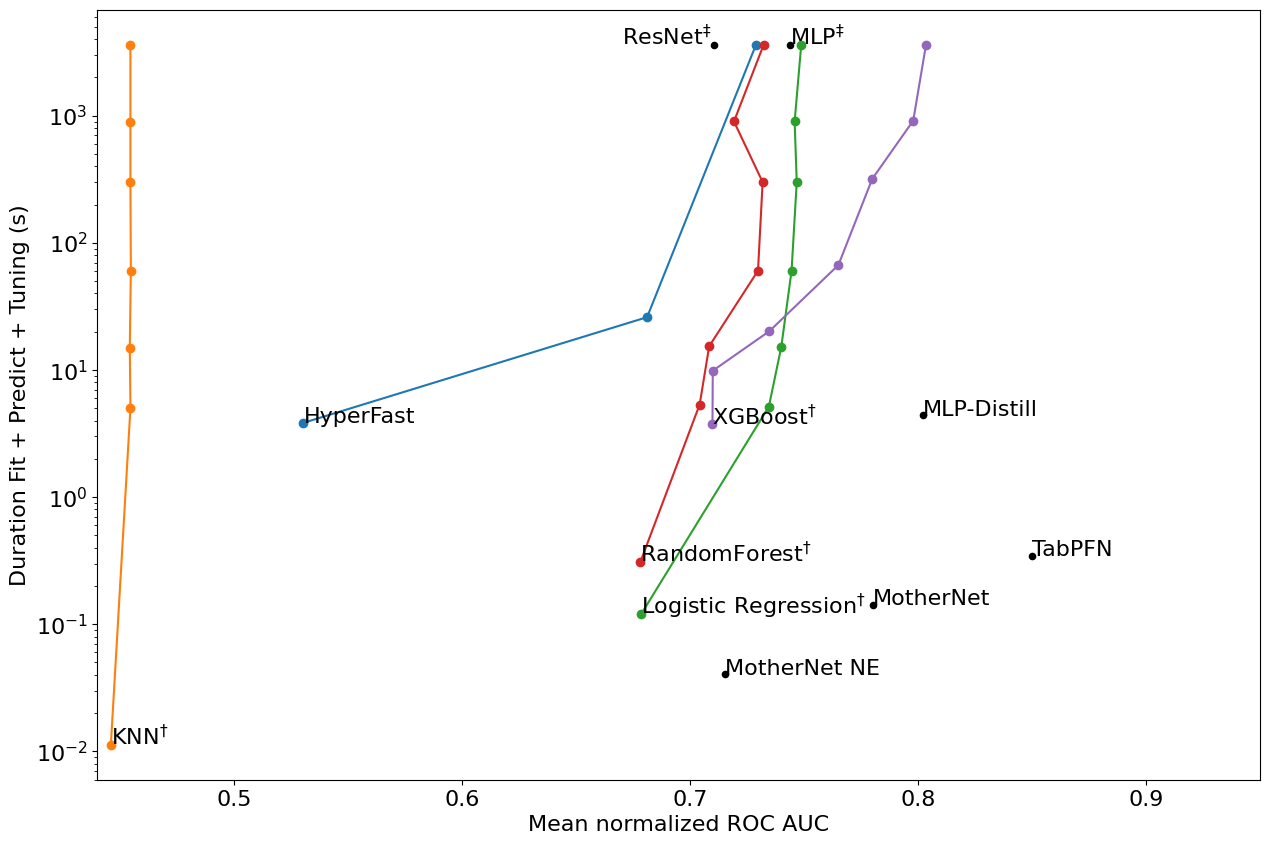

In [38]:
all_times['total_time'] = all_times.max_time + all_times.fit_time + all_times.inference_time
plt.figure(figsize=(15, 10))
ax = plt.gca()
for model in all_times.model.unique():
    if model == "MotherNet FT$^\ddag$":
        continue
    this_model = all_times[all_times.model == model].sort_values("total_time").reset_index(drop=True)
    if len(this_model) > 1:
        this_model.plot(x="mean_metric", y="total_time", ax=ax, marker="o", legend=False)
    else:
        this_model.plot(x="mean_metric", y="total_time", ax=ax,  marker="o", kind="scatter", c="k")
    print(model)
    if model in ["ResNet$^\ddag$"]:
        plt.text(this_model["mean_metric"].iloc[0] - .04, this_model["total_time"].iloc[0], model)
    else:
        plt.text(this_model["mean_metric"].iloc[0], this_model["total_time"].iloc[0], model)

plt.yscale("log")
plt.xlim(0.44, 0.95)
plt.ylabel("Duration Fit + Predict + Tuning (s)")
plt.xlabel("Mean normalized ROC AUC")

In [120]:
result_table

,fit_time,inference_time,ROC AUC,fit_time std,inference_time std,ROC AUC std,Normalized ROC AUC,Normalized ROC AUC std,rank,fit+predict
model,,,,,,,,,,
TabPFN,0.008,0.337,0.893,0.016,0.001,0.003,0.850,0.026,3.733,0.344
MLP-Distill,4.382,0.002,0.885,0.042,0.000,0.004,0.802,0.027,4.767,4.384
MotherNet,0.136,0.006,0.889,0.029,0.000,0.004,0.780,0.037,5.567,0.143
XGBoost$^\dag$,8.270,0.032,0.885,6.404,0.026,0.006,0.757,0.046,5.933,8.301
MotherNet NE,0.040,0.001,0.887,0.007,0.000,0.003,0.716,0.026,6.500,0.040
MLP$^\ddag$,2.257,0.001,0.882,0.225,0.000,0.003,0.744,0.025,7.267,2.258
Logistic Regression$^\dag$,0.177,0.001,0.882,0.045,0.001,0.003,0.734,0.034,7.300,0.178
ResNet$^\ddag$,1.668,0.001,0.877,0.265,0.000,0.004,0.710,0.025,7.867,1.669
RandomForest$^\dag$,0.278,0.041,0.878,0.047,0.007,0.003,0.715,0.030,7.900,0.319


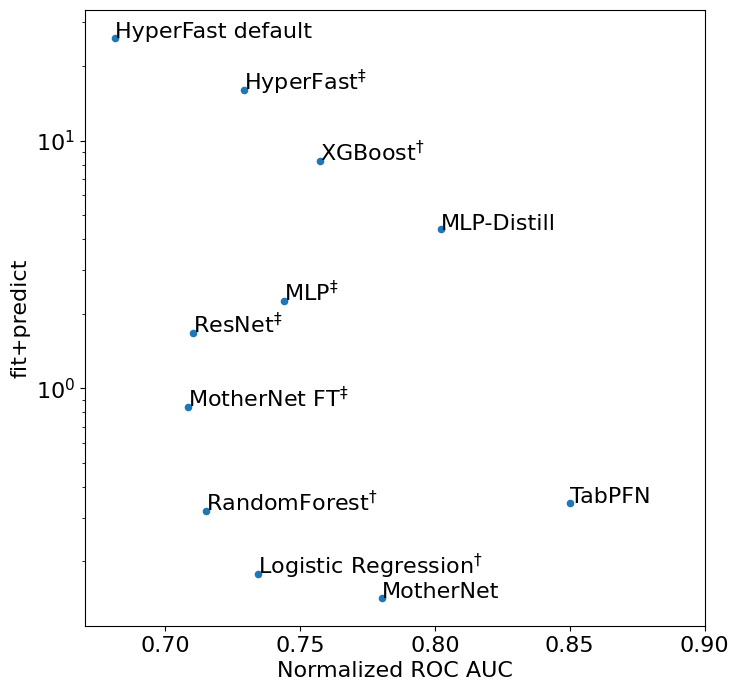

In [116]:
plt.figure(figsize=(8, 8))
for_scatter_plot = result_table.dropna(subset="rank").drop(index=["KNN$^\dag$", "HyperFast no FT", "MotherNet NE"])
#for_scatter_plot = result_table.dropna(subset="rank").drop(index=["KNN$^\dag$"])
for_scatter_plot.plot(x="Normalized ROC AUC", y="fit+predict", kind="scatter", ax=plt.gca())
for  name, row in for_scatter_plot.iterrows():
    plt.text(row["Normalized ROC AUC"], row["fit+predict"], name)
plt.yscale("log")
plt.xlim(0.67, 0.9)
plt.savefig("../figures/time_roc_scatter.pdf", dpi=300, bbox_inches="tight")

In [35]:
def fmt(x):
    return f"{x:.3f}"

In [36]:
for_paper = result_table[['rank', 'Normalized ROC AUC', 'Normalized ROC AUC std', 'ROC AUC', 'ROC AUC std', 'fit_time', 'inference_time', "fit+predict"]].copy()
for_paper['Normalized ROC AUC'] = for_paper['Normalized ROC AUC'].apply(fmt) + "$\pm$" + for_paper['Normalized ROC AUC std'].apply(fmt)
for_paper['ROC AUC'] = for_paper['ROC AUC'].apply(fmt) + "$\pm$" + for_paper['ROC AUC std'].apply(fmt)
for_paper = for_paper.drop(columns=['Normalized ROC AUC std', 'ROC AUC std'])
for_paper.columns = ['rank', 'normalized AUC', 'AUC', 'fit time', 'predict time', "fit + predict" ]
print(for_paper.to_latex(float_format="%.3f"))

\begin{tabular}{lrllrrr}
\toprule
 & rank & normalized AUC & AUC & fit time & predict time & fit + predict \\
model &  &  &  &  &  &  \\
\midrule
TabPFN & 3.733 & 0.850$\pm$0.026 & 0.893$\pm$0.003 & 0.008 & 0.337 & 0.344 \\
MLP-Distill & 4.767 & 0.802$\pm$0.027 & 0.885$\pm$0.004 & 4.382 & 0.002 & 4.384 \\
MotherNet & 5.567 & 0.780$\pm$0.037 & 0.889$\pm$0.004 & 0.136 & 0.006 & 0.143 \\
XGBoost$^\dag$ & 5.933 & 0.757$\pm$0.046 & 0.885$\pm$0.006 & 8.270 & 0.032 & 8.301 \\
MotherNet NE & 6.500 & 0.716$\pm$0.026 & 0.887$\pm$0.003 & 0.040 & 0.001 & 0.040 \\
MLP$^\ddag$ & 7.267 & 0.744$\pm$0.025 & 0.882$\pm$0.003 & 2.257 & 0.001 & 2.258 \\
Logistic Regression$^\dag$ & 7.300 & 0.734$\pm$0.034 & 0.882$\pm$0.003 & 0.177 & 0.001 & 0.178 \\
ResNet$^\ddag$ & 7.867 & 0.710$\pm$0.025 & 0.877$\pm$0.004 & 1.668 & 0.001 & 1.669 \\
RandomForest$^\dag$ & 7.900 & 0.715$\pm$0.030 & 0.878$\pm$0.003 & 0.278 & 0.041 & 0.319 \\
MotherNet FT$^\ddag$ & 7.900 & 0.708$\pm$0.024 & 0.883$\pm$0.004 & 0.839 & 0.002 & 0

In [37]:
# plt.figure(figsize=(4, 3), dpi=300)

# compare_splits_varies = compare_splits_over_time_valid_normalized[compare_splits_over_time_valid_normalized.model.isin(varies_over_time)]
# compare_splits_fixed = compare_splits_over_time_valid_normalized[~compare_splits_over_time_valid_normalized.model.isin(varies_over_time)]


# ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model",  marker="o", palette=color_mapping)

# compare_splits_fixed_dummy = compare_splits_over_time_valid_normalized.copy()
# compare_splits_fixed_dummy['max_time'] = compare_splits_varies.max_time.max()
# sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
#               x="max_time", y="mean_metric", hue="model", ax=ax, palette=color_mapping)
# plt.xscale("log")
# #legend = plt.legend(loc=(1.1 , .3))
# legend = ax.get_legend()
# legend.remove()
# #ax.set_ylim(0.85, 0.90)
# ax.set_ylabel("mean ROC AUC")
# ax.set_xlabel("max time (s)")
# plt.savefig("../figures/mean_auc_over_time_valid_normalized.pdf", bbox_inches="tight")

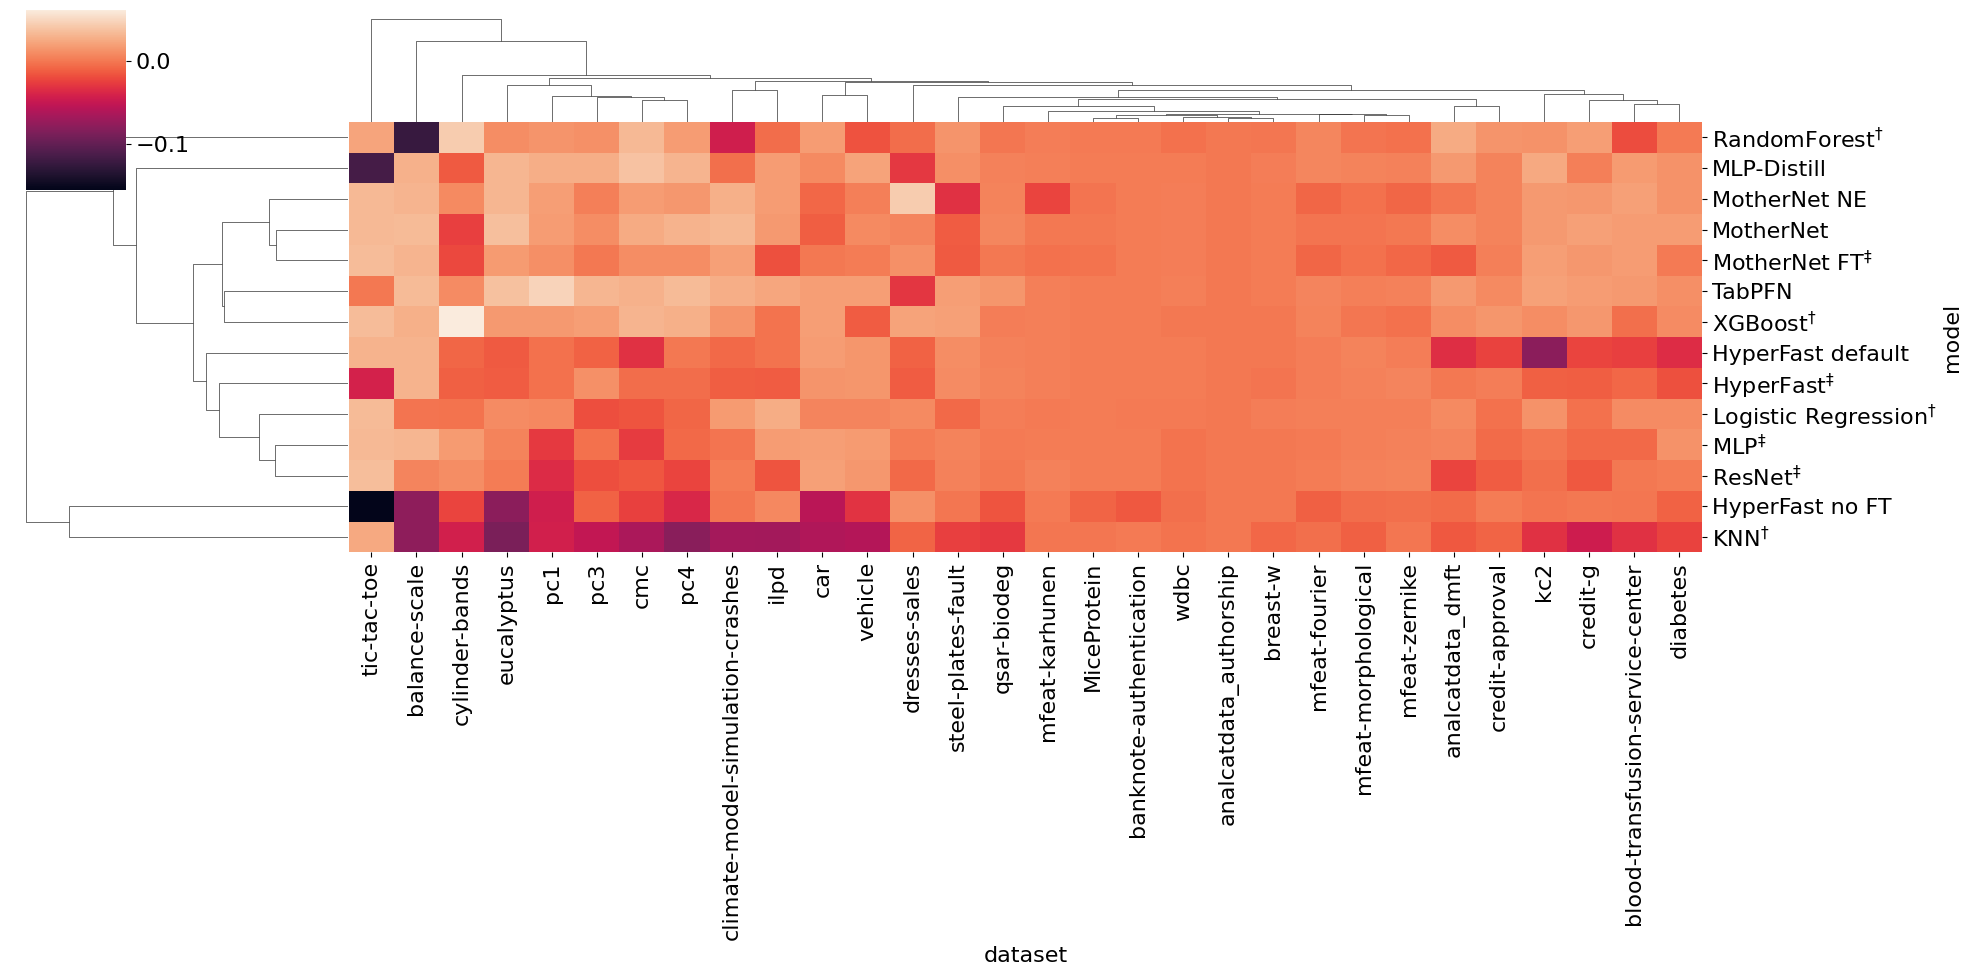

In [38]:
sns.clustermap((pivoted_for_cd_test.T - pivoted_for_cd_test.T.mean()), figsize=(20, 10))

In [39]:
print(pivoted_for_cd_test.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
model & HyperFast default & HyperFast no FT & HyperFast$^\ddag$ & KNN$^\dag$ & Logistic Regression$^\dag$ & MLP$^\ddag$ & MLP-Distill & MotherNet & MotherNet FT$^\ddag$ & MotherNet NE & RandomForest$^\dag$ & ResNet$^\ddag$ & TabPFN & XGBoost$^\dag$ \\
dataset &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
MiceProtein & 1.00 & 0.99 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 \\
analcatdata_authorship & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 \\
analcatdata_dmft & 0.53 & 0.55 & 0.56 & 0.55 & 0.57 & 0.57 & 0.58 & 0.57 & 0.55 & 0.56 & 0.59 & 0.54 & 0.58 & 0.57 \\
balance-scale & 0.99 & 0.89 & 0.99 & 0.89 & 0.96 & 0.99 & 0.99 & 1.00 & 0.99 & 0.99 & 0.84 & 0.97 & 1.00 & 0.99 \\
banknote-authentication & 1.00 & 0.98 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 \\
blood-transfusion-service-center & 0.71 & 0.74 & 

In [40]:
((pivoted_for_cd_test.T - pivoted_for_cd_test.T.min()) / (pivoted_for_cd_test.T.max() - pivoted_for_cd_test.T.min())).T

model,HyperFast default,HyperFast no FT,HyperFast$^\ddag$,KNN$^\dag$,Logistic Regression$^\dag$,MLP$^\ddag$,MLP-Distill,MotherNet,MotherNet FT$^\ddag$,MotherNet NE,RandomForest$^\dag$,ResNet$^\ddag$,TabPFN,XGBoost$^\dag$
dataset,,,,,,,,,,,,,,
MiceProtein,1.000,0.000,1.000,0.752,0.936,0.976,0.984,0.857,0.575,0.684,0.930,0.998,0.965,0.982
analcatdata_authorship,0.805,0.813,0.801,0.250,0.916,0.851,0.955,1.000,0.845,0.862,0.000,0.860,0.992,0.768
analcatdata_dmft,0.000,0.468,0.577,0.336,0.723,0.679,0.847,0.744,0.342,0.553,1.000,0.190,0.843,0.746
balance-scale,0.972,0.291,0.974,0.287,0.777,0.984,0.970,0.999,0.977,0.980,0.000,0.822,1.000,0.961
banknote-authentication,1.000,0.000,1.000,0.950,0.983,1.000,1.000,1.000,1.000,1.000,0.980,1.000,1.000,1.000
blood-transfusion-service-center,0.127,0.597,0.463,0.000,0.805,0.490,0.945,0.965,0.963,1.000,0.248,0.615,0.926,0.536
breast-w,0.777,0.775,0.612,0.000,0.960,0.765,1.000,0.908,0.942,0.919,0.641,0.770,0.909,0.728
car,0.985,0.066,0.926,0.000,0.832,0.996,0.863,0.617,0.761,0.666,0.981,1.000,0.991,0.992
climate-model-simulation-crashes,0.608,0.666,0.554,0.000,0.850,0.659,0.635,1.000,0.873,0.963,0.228,0.694,0.955,0.813
